# Training Infrastructure

## Loading data into a dataset dictionary

In [1]:
import pandas as pd
from datasets import Dataset, DatasetDict

train = pd.read_parquet("/home/nikl/programming/fhdw/knowledge_engineering_ausarbeitung/fakenews_detection/data/model_training/train_df.parquet")
valid = pd.read_parquet("/home/nikl/programming/fhdw/knowledge_engineering_ausarbeitung/fakenews_detection/data/model_training/valid_df.parquet")
test = pd.read_parquet("/home/nikl/programming/fhdw/knowledge_engineering_ausarbeitung/fakenews_detection/data/model_training/test_df.parquet")

dataset = DatasetDict(
    {'train':Dataset.from_pandas(train,preserve_index=False),
     'validation': Dataset.from_pandas(valid,preserve_index=False),
     'test':Dataset.from_pandas(test,preserve_index=False)
     }    
)

dataset

DatasetDict({
    train: Dataset({
        features: ['preprocessed_text', 'label', 'label_names'],
        num_rows: 44153
    })
    validation: Dataset({
        features: ['preprocessed_text', 'label', 'label_names'],
        num_rows: 12616
    })
    test: Dataset({
        features: ['preprocessed_text', 'label', 'label_names'],
        num_rows: 6308
    })
})

# Model Training

## Transformer Model Training

### Method for evaluating performance while training

In [2]:
import torch
import evaluate

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

accuracy_metric = evaluate.load("accuracy")
f1_metric = evaluate.load("f1")
precision_metric = evaluate.load("precision")
recall_metric = evaluate.load("recall")

def compute_metrics(pred):
    logits, labels = pred
    predictions = torch.argmax(torch.tensor(logits), dim=-1)
    result = {}
    for metric in [accuracy_metric, f1_metric, precision_metric, recall_metric]:
        result.update(metric.compute(predictions=predictions, references=labels))
    return result

In [3]:
import glob
import os
import pandas as pd

def load_dataset(path):
    parquet_files = glob.glob(f"{path}/*.parquet")
    dataframes = {file.split('/')[-1].replace('.parquet', ''): pd.read_parquet(file) for file in parquet_files}
    
    dataset = DatasetDict(
        {name: Dataset.from_pandas(df, preserve_index=False) for name, df in dataframes.items()}
    )
    return dataset

def save_dataset_as_parquet(dataset_dict, folder_path):
    if not os.path.exists(folder_path):
        os.makedirs(folder_path)
    
    for split, dataset in dataset_dict.items():
        file_path = os.path.join(folder_path, f"{split}.parquet")
        df = dataset.to_pandas()
        df.to_parquet(file_path)

### Tokenizing the Dataset

In [4]:
from transformers import AutoTokenizer, DebertaV2Tokenizer
import os
def tokenize_data(dataset, model_name, model_dir=None, save_and_load=False):
    """"Tokenize the given dataset using the given model tokenizer."""
    if model_name == "microsoft/deberta-v3-base":
        tokenizer = DebertaV2Tokenizer.from_pretrained(model_name, use_fast=True)
    else:
        tokenizer = AutoTokenizer.from_pretrained(model_name) 
        
    def tokenize_and_format(batch):
        tokens = tokenizer(batch['preprocessed_text'], padding=True, truncation=True)
        tokens = {key: torch.tensor(val).to(device) for key, val in tokens.items()}
        tokens['labels'] = torch.tensor(batch['label']).to(device)
        return tokens
    if save_and_load:
        if model_dir and os.path.exists(f"{model_dir}/tokenized_dataset"):
            print(f"Loading tokenized dataset from {model_dir}")
            tokenized_dataset = load_dataset(f"{model_dir}/tokenized_dataset")
        else:
            print(f"Tokenizing Data")
            tokenized_dataset = dataset.map(tokenize_and_format, batched=True)
            print(f"Saving tokenized dataset to {model_dir}")
            save_dataset_as_parquet(tokenized_dataset, f"{model_dir}/tokenized_dataset")
    else:
        print(f"Tokenizing Data")
        tokenized_dataset = dataset.map(tokenize_and_format, batched=True)

    return tokenized_dataset, tokenizer

### Getting Model Path

In [5]:
import shutil
import os
from pathlib import Path
def get_model_dir(model_name, use_peft, from_checkpoint):
    
    root_path = Path().resolve().parent
    
    if use_peft:
        model_dir = f"{root_path}/models/with_peft/{model_name}"
    else:
        model_dir = f"{root_path}/models/without_peft/{model_name}"
    if not os.path.exists(model_dir):
        os.makedirs(model_dir)
        
        if from_checkpoint:
            print(f"WARNING: Cannot continue training from checkpoint as the model directory is empty. Starting from scratch.")
            from_checkpoint = False
        
    elif not from_checkpoint:
    
        input("WARNING: The model directory already exists. As 'from_checkpoint' is set to 'False' the content will be overwritten. Press Enter to continue or Ctrl+C to cancel.")
        # Overwrite the existing directory
        for filename in os.listdir(model_dir):
            file_path = os.path.join(model_dir, filename)
            if os.path.isfile(file_path) or os.path.islink(file_path):
                os.unlink(file_path)
            elif os.path.isdir(file_path):
                shutil.rmtree(file_path)
    
    print(f"Model directory: {model_dir}")
    return model_dir, from_checkpoint

### Looking for Model Checkpoints

In [6]:
import os
def find_model_file(model_dir):
    """
    Look for a model file in the given directory, with the following priority:
    1. model.safetensors or adapter_model.safetensors in the root directory
    2. model.safetensors or adapter_model.safetensors in the latest checkpoint directory
    Returns None if no model file is found.
    """
    checkpoint_dirs = sorted([
        d for d in os.listdir(model_dir) 
        if os.path.isdir(os.path.join(model_dir, d)) 
        and d.startswith('checkpoint-')
    ], key=lambda x: int(x.split('-')[-1]), reverse=True)
    
    # Check each checkpoint directory for model files
    for checkpoint_dir in checkpoint_dirs:
        full_path = os.path.join(model_dir, checkpoint_dir)
        if os.path.exists(os.path.join(full_path, "model.safetensors")) or \
        os.path.exists(os.path.join(full_path, "adapter_model.safetensors")):
            print(f"Found checkpoint model file in: {full_path}")
            return full_path
        else:
            print(f"No model file found in {full_path}")
            return None

### Loading Model Object without PEFT

In [7]:
from transformers import  AutoModelForSequenceClassification
def load_model_object(model_dir, model, config, from_checkpoint=False):
    
    if not from_checkpoint:
        return model

    checkpoint_dir = find_model_file(model_dir)
         
    if checkpoint_dir is None:
        print(f"No checkpoint found in {from_checkpoint}")
        return model 
    else:
        print(f"Loading full model weights from {checkpoint_dir}")
        model = AutoModelForSequenceClassification.from_pretrained(
            checkpoint_dir,
            config=config
        )
        return model

### Setup of PEFT Model

In [8]:
from peft import get_peft_model, LoraConfig, PeftModelForSequenceClassification

def setup_peft(model_name, model, model_dir, from_checkpoint=False):
    if model_name == "distilbert-base-uncased":
        target_modules = ["q_lin", "k_lin", "v_lin"]
    elif model_name == "microsoft/deberta-v3-base":
        target_modules = None
    else:
        target_modules = ["query", "key", "value"]
        
    # PEFT: LoRA configuration
    peft_config = LoraConfig(
        task_type="SEQ_CLS",
        r=16,
        lora_alpha=32,
        lora_dropout=0.1,
        target_modules=target_modules
    )
    model = get_peft_model(model, peft_config)
    
    if from_checkpoint:
        checkpoint_dir = find_model_file(model_dir)
        if checkpoint_dir:
            print(f"Loading LoRA weights from {checkpoint_dir}")
            from_pretrained_kwargs = {
                "is_trainable": True,
                "inference_mode": False
            }
            model = PeftModelForSequenceClassification.from_pretrained(
                model,
                checkpoint_dir,
                **from_pretrained_kwargs,
            )
        else:
            print(f"No checkpoint found in {model_dir}")
    return model

### Load Previous Training Config

In [9]:
import json
def get_completed_epochs(model_dir):
    checkpoint_dir = find_model_file(model_dir)
    trainer_state_path = os.path.join(checkpoint_dir, "trainer_state.json")
    if os.path.exists(trainer_state_path):
        with open(trainer_state_path, "r") as f:
            trainer_state = json.load(f)
            completed_epochs = trainer_state.get("epoch", 0)
            per_device_train_batch_size = trainer_state.get("train_batch_size", 32)
            print(f"Resuming from checkpoint. Completed epochs: {completed_epochs}, Previous Batch Size: {per_device_train_batch_size}")
        return completed_epochs, per_device_train_batch_size 
    else:
        print("Starting from scratch.")
        return None, None

In [10]:
import pandas as pd
import json
from datetime import datetime
import os
from pathlib import Path
def process_training_logs(data, use_peft, model_name):
    """
    Process training logs into separate training and evaluation dataframes with Parquet storage.
    
    Args:
        data (list): List of dictionaries containing training and evaluation logs
        save_dir (str, optional): Directory to save the processed DataFrames as Parquet files
        
    Returns:
        tuple: (training_df, eval_df, summary_df) containing processed DataFrames
    """
    root_path = Path().resolve().parent
    if use_peft:
        save_dir = f"{root_path}/data/model_evaluation/with_peft/{model_name}"
    else:
        save_dir = f"{root_path}/data/model_evaluation/without_peft/{model_name}"
    # Initialize log containers
    training_logs = []
    eval_logs = []
    summary_logs = []
    
    for entry in data:
        # Process evaluation logs
        if any(key.startswith('eval_') for key in entry.keys()):
            eval_entry = {'epoch': entry.get('epoch'), 'step': entry.get('step')}
            for key, value in entry.items():
                if key.startswith('eval_'):
                    clean_key = key[5:]
                    eval_entry[clean_key] = value
            eval_logs.append(eval_entry)
            
        # Process training summary logs
        elif 'train_loss' in entry:
            summary_entry = {
                'epoch': entry.get('epoch'),
                'step': entry.get('step'),
                'total_flos': entry.get('total_flos'),
                'train_loss': entry.get('train_loss'),
                'train_runtime': entry.get('train_runtime'),
                'train_samples_per_second': entry.get('train_samples_per_second'),
                'train_steps_per_second': entry.get('train_steps_per_second')
            }
            summary_logs.append(summary_entry)
            
        # Process regular training logs
        else:
            training_logs.append(entry)
    
    # Create DataFrames
    training_df = pd.DataFrame(training_logs)
    eval_df = pd.DataFrame(eval_logs)
    summary_df = pd.DataFrame(summary_logs)
    
    # Sort and clean up DataFrames
    if not training_df.empty:
        training_df = training_df.sort_values(['epoch', 'step']).reset_index(drop=True)
        training_df['loss_change'] = training_df['loss'].diff() if 'loss' in training_df.columns else None
        training_df['loss_change_rate'] = (training_df['loss_change'] / training_df['loss'].shift(1)) if 'loss' in training_df.columns else None

    if not eval_df.empty:
        eval_df = eval_df.sort_values(['epoch', 'step']).reset_index(drop=True)
        if 'loss' in eval_df.columns:
            eval_df['loss_change'] = eval_df['loss'].diff()
            eval_df['best_loss_so_far'] = eval_df['loss'].cummin()
        if 'accuracy' in eval_df.columns:
            eval_df['best_accuracy_so_far'] = eval_df['accuracy'].cummax()

    # Save DataFrames if directory is provided
    if save_dir:
        timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')
        os.makedirs(save_dir, exist_ok=True)
        
        # Save DataFrames as Parquet with optimal compression
        if not training_df.empty:
            training_df.to_parquet(
                os.path.join(save_dir, f'training_logs.parquet'),
                compression='brotli',  # Typically best compression ratio for ML metrics
                index=False
            )
        if not eval_df.empty:
            eval_df.to_parquet(
                os.path.join(save_dir, f'eval_logs.parquet'),
                compression='brotli',
                index=False
            )
        if not summary_df.empty:
            summary_df.to_parquet(
                os.path.join(save_dir, f'summary_logs.parquet'),
                compression='brotli',
                index=False
            )
            
        # Save minimal training configuration summary
        config_summary = {
            'total_steps': len(training_df) if not training_df.empty else 0,
            'total_epochs': float(training_df['epoch'].max()) if not training_df.empty else 0,
            'eval_frequency': len(eval_df) / len(training_df) if not training_df.empty and not eval_df.empty else 0,
            'final_train_loss': float(training_df['loss'].iloc[-1]) if not training_df.empty and 'loss' in training_df else None,
            'best_eval_loss': float(eval_df['loss'].min()) if not eval_df.empty and 'loss' in eval_df else None,
            'best_eval_accuracy': float(eval_df['accuracy'].max()) if not eval_df.empty and 'accuracy' in eval_df else None,
            'timestamp': timestamp
        }
        
        with open(os.path.join(save_dir, f'training_summary.json'), 'w') as f:
            json.dump(config_summary, f)
    
    return training_df, eval_df, summary_df

In [11]:
import pandas as pd
import numpy as np
from sklearn.metrics import confusion_matrix, roc_curve, auc
import torch
from datetime import datetime
import os

def process_model_evaluation(trainer, tokenized_dataset, test_results, model_name, use_peft):
    """
    Process and save detailed evaluation metrics for the model.
    
    Args:
        trainer: HuggingFace trainer instance
        tokenized_dataset: Dictionary containing the dataset splits
        test_results: Dictionary containing initial test results
        model_name: Name of the model being evaluated
        use_peft: Boolean indicating if PEFT was used
        save_dir: Directory to save the evaluation results
        
    Returns:
        dict: Dictionary containing all computed metrics
    """
    
    root_path = Path().resolve().parent
    if use_peft:
        save_dir = f"{root_path}/data/model_evaluation/with_peft/{model_name}"
    else:
        save_dir = f"{root_path}/data/model_evaluation/without_peft/{model_name}"
        
    os.makedirs(save_dir, exist_ok=True)
    
    # Get predictions and labels for the test set
    test_pred = trainer.predict(tokenized_dataset["test"])
    predictions = np.argmax(test_pred.predictions, axis=1)
    labels = test_pred.label_ids
    
    # Calculate probabilities for ROC curve
    probabilities = torch.nn.functional.softmax(torch.tensor(test_pred.predictions), dim=1).numpy()
    
    # Calculate confusion matrix
    cm = confusion_matrix(labels, predictions)
    tn, fp, fn, tp = cm.ravel()
    
    # Calculate ROC curve and AUC
    fpr, tpr, _ = roc_curve(labels, probabilities[:, 1])
    roc_auc = auc(fpr, tpr)
    
    # Compile all metrics
    metrics_dict = {
        'model_name': model_name,
        'use_peft': use_peft,
        'accuracy': test_results['eval_accuracy'],
        'precision': test_results['eval_precision'],
        'recall': test_results['eval_recall'],
        'f1': test_results['eval_f1'],
        'loss': test_results['eval_loss'],
        'roc_auc': roc_auc,
        'true_negatives': int(tn),
        'false_positives': int(fp),
        'false_negatives': int(fn),
        'true_positives': int(tp)
    }
    
    # Create DataFrames for different aspects of evaluation
    main_metrics_df = pd.DataFrame([metrics_dict])
    
    # Create confusion matrix DataFrame
    confusion_df = pd.DataFrame({
        'model_name': [model_name],
        'predicted_negative_actual_negative': [tn],
        'predicted_positive_actual_negative': [fp],
        'predicted_negative_actual_positive': [fn],
        'predicted_positive_actual_positive': [tp]
    })
    
    # Create ROC curve DataFrame
    roc_df = pd.DataFrame({
        'model_name': model_name,
        'false_positive_rate': fpr,
        'true_positive_rate': tpr,
        'auc': roc_auc
    })
    
    # Create predictions DataFrame
    predictions_df = pd.DataFrame({
        'model_name': model_name,
        'true_label': labels,
        'predicted_label': predictions,
        'confidence_negative': probabilities[:, 0],
        'confidence_positive': probabilities[:, 1]
    })
    
    
    main_metrics_df.to_parquet(f'{save_dir}/sklearn_metrics.parquet', compression='brotli', index=False)
    confusion_df.to_parquet(f'{save_dir}/sklearn_confusion.parquet', compression='brotli', index=False)
    roc_df.to_parquet(f'{save_dir}/sklearn_roc.parquet', compression='brotli', index=False)
    predictions_df.to_parquet(f'{save_dir}/sklearn_predictions.parquet', compression='brotli', index=False)
    
    return metrics_dict

### Code for Transformer Model Training

In [14]:
from transformers import AutoConfig, AutoModelForSequenceClassification, TrainingArguments, Trainer
from pprint import pprint
def fine_tune_model(
    model_name, 
    dataset, 
    training_batch_size=32, 
    epochs=5,
    use_peft=True,
    from_checkpoint=True
):
    print(f"Using Model: {model_name} with device {device}")
    print(f"Training mode: {'PEFT' if use_peft else 'Full model'}")
    
    model_dir, from_checkpoint = get_model_dir(model_name, use_peft, from_checkpoint)
    
    tokenized_dataset, tokenizer = tokenize_data(dataset, model_name, model_dir)

    config = AutoConfig.from_pretrained(model_name, num_labels=2)
    model = AutoModelForSequenceClassification.from_pretrained(model_name, config=config).to(device)
    
    if use_peft:
        model = setup_peft(model_name, model, model_dir, from_checkpoint=from_checkpoint)
        
    else:
        model = load_model_object(model_dir, model, config, from_checkpoint=from_checkpoint)

    model = model.to(device)
    
    if from_checkpoint:
        completed_epochs, old_batch_size = get_completed_epochs(model_dir)
        if completed_epochs is not None:
            epochs = completed_epochs + epochs
        if old_batch_size is not None:
            training_batch_size = old_batch_size

    training_args = TrainingArguments(
        output_dir=model_dir,
        num_train_epochs=epochs,
        per_device_train_batch_size=training_batch_size,
        per_device_eval_batch_size=training_batch_size,
        learning_rate=2e-5,
        weight_decay=0.01,
        evaluation_strategy="steps",
        eval_steps=200,
        save_strategy="steps",
        save_steps=200,
        logging_dir=f"{model_dir}/logs",
        save_total_limit=4,
        fp16=True,
        logging_steps=50,
        report_to="tensorboard",
        lr_scheduler_type="linear",
        warmup_steps=500,
        metric_for_best_model="eval_loss",
        load_best_model_at_end=True,
    )
    
    trainer = Trainer(
        model=model,
        args=training_args,
        train_dataset=tokenized_dataset["train"],
        eval_dataset=tokenized_dataset["validation"],
        compute_metrics=compute_metrics,
    )
    
    print("Starting Training")
    
    trainer.train(resume_from_checkpoint=from_checkpoint)
    test_results = trainer.evaluate(eval_dataset=tokenized_dataset["test"])
    print("Test Results:")
    pprint(f"{test_results}")
    
    process_model_evaluation(
        trainer=trainer,
        tokenized_dataset=tokenized_dataset,
        test_results=test_results,
        model_name=model_name,
        use_peft=use_peft,
    )
    process_training_logs(trainer.state.log_history, use_peft, model_name)
    
    if use_peft:
        model.save_pretrained(model_dir)
    else:
        trainer.save_model(model_dir)
    tokenizer.save_pretrained(model_dir)
    
    torch.cuda.empty_cache()
    print(f"Finished training {model_name}. Model saved to {model_dir}")

In [15]:
from warnings import filterwarnings
filterwarnings("ignore", category=FutureWarning)

possible_models = {"bert": "bert-base-uncased", "distilbert": "distilbert-base-uncased", "roberta": "roberta-base", "deberta": "microsoft/deberta-v3-base"}

current_model = possible_models["distilbert"]

fine_tune_model(current_model, dataset, training_batch_size=32, epochs=1, use_peft=True, from_checkpoint=False)



Using Model: distilbert-base-uncased with device cuda
Training mode: PEFT
Model directory: /home/nikl/programming/fhdw/knowledge_engineering_ausarbeitung/fakenews_detection/models/with_peft/distilbert-base-uncased
Tokenizing Data


Map:   0%|          | 0/44153 [00:00<?, ? examples/s]

Map:   0%|          | 0/12616 [00:00<?, ? examples/s]

Map:   0%|          | 0/6308 [00:00<?, ? examples/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Starting Training


Step,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
200,0.675000,0.670359,0.559845,0.036439,0.990566,0.018561
400,0.528300,0.479799,0.786937,0.758621,0.770944,0.746686
600,0.369100,0.346627,0.848288,0.829320,0.836782,0.821990
800,0.297900,0.294552,0.874366,0.859871,0.860099,0.859643
1000,0.280700,0.270455,0.885938,0.869431,0.893177,0.846915
1200,0.244700,0.252062,0.897511,0.885220,0.889087,0.881386


Test Results:
("{'eval_loss': 0.24135418236255646, 'eval_accuracy': 0.901712111604312, "
 "'eval_f1': 0.8904980572235959, 'eval_precision': 0.8898693963995764, "
 "'eval_recall': 0.8911276069282432, 'eval_runtime': 26.2179, "
 "'eval_samples_per_second': 240.599, 'eval_steps_per_second': 7.552, 'epoch': "
 '1.0}')
Finished training distilbert-base-uncased. Model saved to /home/nikl/programming/fhdw/knowledge_engineering_ausarbeitung/fakenews_detection/models/with_peft/distilbert-base-uncased


In [19]:
import pandas as pd

import pandas as pd

def process_training_logs(data):
    """
    Process training logs into separate training and evaluation dataframes.
    
    Args:
        data (list): List of dictionaries containing training and evaluation logs
        
    Returns:
        tuple: (training_df, eval_df) containing processed DataFrames
    """
    # Separate training and evaluation logs
    training_logs = []
    eval_logs = []
    
    for entry in data:
        # Check if this is an evaluation log
        if 'eval_accuracy' in entry:
            # Create a flattened version of eval metrics
            eval_entry = {
                'epoch': entry['epoch'],
                'step': entry['step'],
                'accuracy': entry['eval_accuracy'],
                'f1': entry['eval_f1'],
                'loss': entry['eval_loss'],
                'precision': entry['eval_precision'],
                'recall': entry['eval_recall'],
                'runtime': entry['eval_runtime'],
                'samples_per_second': entry['eval_samples_per_second'],
                'steps_per_second': entry['eval_steps_per_second']
            }
            eval_logs.append(eval_entry)
        # Check if this is a training summary
        elif 'train_loss' in entry:
            # Skip these as they're summary statistics
            continue
        # Regular training log
        else:
            training_logs.append(entry)
    
    # Create DataFrames
    training_df = pd.DataFrame(training_logs)
    eval_df = pd.DataFrame(eval_logs)
    
    # Sort by epoch
    training_df = training_df.sort_values('epoch').reset_index(drop=True)
    eval_df = eval_df.sort_values('epoch').reset_index(drop=True)
    
    return training_df, eval_df

# Your data
data = [
    {'epoch': 0.036231884057971016, 'grad_norm': 0.5364510416984558, 'learning_rate': 2.0000000000000003e-06, 'loss': 0.6966, 'step': 50},
    {'epoch': 0.07246376811594203, 'grad_norm': 2.2992756366729736, 'learning_rate': 4.000000000000001e-06, 'loss': 0.6905, 'step': 100},
    {'epoch': 0.10869565217391304, 'grad_norm': 1.4845210313796997, 'learning_rate': 6e-06, 'loss': 0.6805, 'step': 150},
    {'epoch': 0.14492753623188406, 'grad_norm': 0.7515935301780701, 'learning_rate': 8.000000000000001e-06, 'loss': 0.6733, 'step': 200},
    {'epoch': 0.18115942028985507, 'grad_norm': 0.7503940463066101, 'learning_rate': 1e-05, 'loss': 0.6644, 'step': 250},
    {'epoch': 0.21739130434782608, 'grad_norm': 1.3295385837554932, 'learning_rate': 1.2e-05, 'loss': 0.6425, 'step': 300},
    {'epoch': 0.2536231884057971, 'grad_norm': 0.8211269378662109, 'learning_rate': 1.4e-05, 'loss': 0.6071, 'step': 350},
    {'epoch': 0.2898550724637681, 'grad_norm': 1.3259072303771973, 'learning_rate': 1.6000000000000003e-05, 'loss': 0.5227, 'step': 400},
    {'epoch': 0.32608695652173914, 'grad_norm': 1.5550689697265625, 'learning_rate': 1.8e-05, 'loss': 0.4599, 'step': 450},
    {'epoch': 0.36231884057971014, 'grad_norm': 1.5907379388809204, 'learning_rate': 2e-05, 'loss': 0.4131, 'step': 500},
    {'epoch': 0.39855072463768115, 'grad_norm': 2.9928290843963623, 'learning_rate': 1.8863636363636366e-05, 'loss': 0.393, 'step': 550},
    {'epoch': 0.43478260869565216, 'grad_norm': 1.1106994152069092, 'learning_rate': 1.772727272727273e-05, 'loss': 0.3567, 'step': 600},
    {'epoch': 0.47101449275362317, 'grad_norm': 1.1489901542663574, 'learning_rate': 1.6590909090909094e-05, 'loss': 0.3144, 'step': 650},
    {'epoch': 0.5072463768115942, 'grad_norm': 1.7643964290618896, 'learning_rate': 1.5454545454545454e-05, 'loss': 0.3224, 'step': 700},
    {'epoch': 0.5434782608695652, 'grad_norm': 2.4669594764709473, 'learning_rate': 1.431818181818182e-05, 'loss': 0.3227, 'step': 750},
    {'epoch': 0.5797101449275363, 'grad_norm': 1.7595874071121216, 'learning_rate': 1.3181818181818183e-05, 'loss': 0.2898, 'step': 800},
    {'epoch': 0.6159420289855072, 'grad_norm': 3.6859381198883057, 'learning_rate': 1.2045454545454547e-05, 'loss': 0.2841, 'step': 850},
    {'epoch': 0.6521739130434783, 'grad_norm': 8.550923347473145, 'learning_rate': 1.0909090909090909e-05, 'loss': 0.2796, 'step': 900},
    {'epoch': 0.6884057971014492, 'grad_norm': 1.7453999519348145, 'learning_rate': 9.772727272727273e-06, 'loss': 0.247, 'step': 950},
    {'epoch': 0.7246376811594203, 'grad_norm': 2.964832067489624, 'learning_rate': 8.636363636363637e-06, 'loss': 0.2616, 'step': 1000},
    {'epoch': 0.7608695652173914, 'grad_norm': 2.4690868854522705, 'learning_rate': 7.500000000000001e-06, 'loss': 0.2479, 'step': 1050},
    {'epoch': 0.7971014492753623, 'grad_norm': 1.5214488506317139, 'learning_rate': 6.363636363636364e-06, 'loss': 0.2516, 'step': 1100},
    {'epoch': 0.8333333333333334, 'grad_norm': 3.340683698654175, 'learning_rate': 5.2272727272727274e-06, 'loss': 0.2454, 'step': 1150},
    {'epoch': 0.8695652173913043, 'grad_norm': 2.880979299545288, 'learning_rate': 4.0909090909090915e-06, 'loss': 0.233, 'step': 1200},
    {'epoch': 0.9057971014492754, 'grad_norm': 5.6686882972717285, 'learning_rate': 2.954545454545455e-06, 'loss': 0.2426, 'step': 1250},
    {'epoch': 0.9420289855072463, 'grad_norm': 4.9191365242004395, 'learning_rate': 1.8181818181818183e-06, 'loss': 0.2192, 'step': 1300},
    {'epoch': 0.9782608695652174, 'grad_norm': 4.597878932952881, 'learning_rate': 6.818181818181818e-07, 'loss': 0.2154, 'step': 1350},
    {'epoch': 1.0, 'eval_accuracy': 0.9026632847178186, 'eval_f1': 0.8912889518413598, 'eval_loss': 0.22579501569271088, 'eval_precision': 0.8928698119900674, 'eval_recall': 0.8897136797454931, 'eval_runtime': 23.3491, 'eval_samples_per_second': 270.16, 'eval_steps_per_second': 8.48, 'step': 1380},
    {'epoch': 1.0, 'step': 1380, 'total_flos': 5989150309134336.0, 'train_loss': 0.3953918961511142, 'train_runtime': 426.3933, 'train_samples_per_second': 103.55, 'train_steps_per_second': 3.236},
    {'epoch': 1.0, 'eval_accuracy': 0.9026632847178186, 'eval_f1': 0.8912889518413598, 'eval_loss': 0.22579501569271088, 'eval_precision': 0.8928698119900674, 'eval_recall': 0.8897136797454931, 'eval_runtime': 24.3405, 'eval_samples_per_second': 259.157, 'eval_steps_per_second': 8.135, 'step': 1380}
]

training_df, eval_df = process_training_logs(data)

# View training metrics
print("Training DataFrame:")
display(training_df)

# View evaluation metrics
print("\nEvaluation DataFrame:")
display(eval_df)

# # Split the data into two separate lists: training and evaluation
# train_data = []
# eval_data = []

# for entry in data:
#     if 'train_loss' in entry:
#         train_data.append(entry)
#     elif 'eval_accuracy' in entry:
#         eval_data.append(entry)

# # Convert both lists to DataFrames
# train_df = pd.DataFrame(train_data)
# eval_df = pd.DataFrame(eval_data)

# # Optionally, if you want to merge the two DataFrames to have everything in a single frame (with NaN values where data is missing):
# merged_df = pd.merge(train_df, eval_df, on='step', how='outer')

# # # Save both DataFrames to Parquet files
# # train_df.to_parquet('train_metrics.parquet', index=False)
# # eval_df.to_parquet('eval_metrics.parquet', index=False)

# # # Optionally save the merged dataframe
# # merged_df.to_parquet('merged_metrics.parquet', index=False)

# print("Training DataFrame:")
# display(train_df.head())
# print("\nEvaluation DataFrame:")
# display(eval_df.head())
# print("\nMerged DataFrame:")
# display(merged_df.head())


Training DataFrame:


,epoch,grad_norm,learning_rate,loss,step
0,0.036232,0.536451,2.000000e-06,0.6966,50
1,0.072464,2.299276,4.000000e-06,0.6905,100
2,0.108696,1.484521,6.000000e-06,0.6805,150
3,0.144928,0.751594,8.000000e-06,0.6733,200
4,0.181159,0.750394,1.000000e-05,0.6644,250
5,0.217391,1.329539,1.200000e-05,0.6425,300
6,0.253623,0.821127,1.400000e-05,0.6071,350
7,0.289855,1.325907,1.600000e-05,0.5227,400
8,0.326087,1.555069,1.800000e-05,0.4599,450
9,0.362319,1.590738,2.000000e-05,0.4131,500



Evaluation DataFrame:


,epoch,step,accuracy,f1,loss,precision,recall,runtime,samples_per_second,steps_per_second
0,1.0,1380,0.902663,0.891289,0.225795,0.89287,0.889714,23.3491,270.160,8.480
1,1.0,1380,0.902663,0.891289,0.225795,0.89287,0.889714,24.3405,259.157,8.135


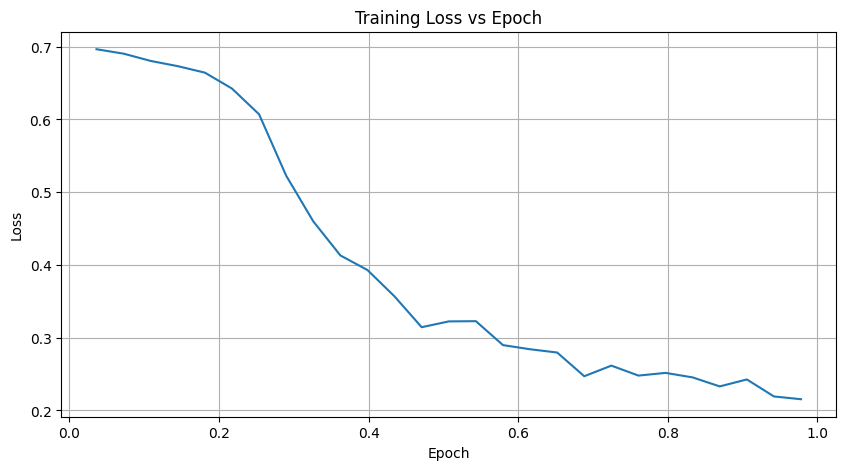

In [20]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
plt.plot(training_df['epoch'], training_df['loss'])
plt.title('Training Loss vs Epoch')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(True)


Loss Statistics:
train_loss_final: 0.2154
train_loss_min: 0.2154
train_loss_max: 0.6966
train_loss_mean: 0.3991
val_loss_final: 0.2258
val_loss_min: 0.2258
val_loss_max: 0.2258
val_loss_mean: 0.2258


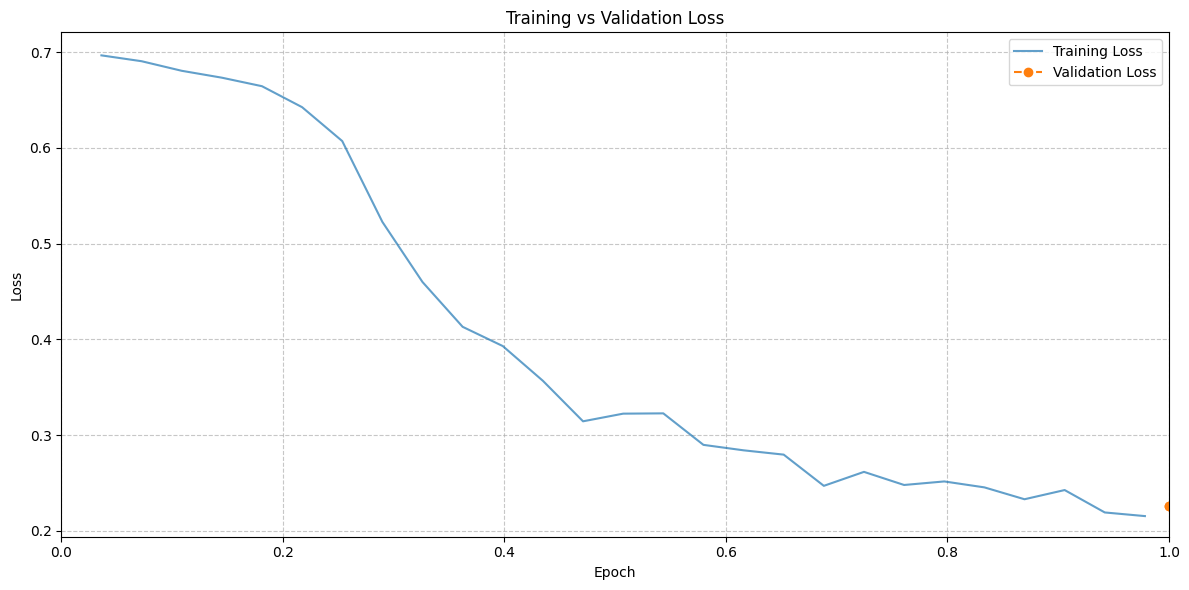

In [21]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

def plot_train_val_loss(training_df, eval_df, figsize=(12, 6)):
    """
    Plot training and validation loss over time.
    
    Args:
        training_df (pd.DataFrame): Training metrics DataFrame
        eval_df (pd.DataFrame): Evaluation metrics DataFrame
        figsize (tuple): Figure size (width, height)
    """
    plt.figure(figsize=figsize)
    
    # Plot training loss
    plt.plot(training_df['epoch'], training_df['loss'], 
             label='Training Loss', 
             alpha=0.7,
             color='#1f77b4')
    
    # Plot evaluation loss
    plt.plot(eval_df['epoch'], eval_df['loss'],
             label='Validation Loss',
             marker='o',
             linestyle='--',
             color='#ff7f0e')
    
    plt.title('Training vs Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.grid(True, alpha=0.3)
    plt.legend()
    
    # Add light grid
    plt.grid(True, linestyle='--', alpha=0.7)
    
    # Ensure y-axis starts from 0 or min loss, whichever is lower
    min_loss = min(training_df['loss'].min(), eval_df['loss'].min())
    plt.ylim(bottom=max(0, min_loss * 0.9))
    
    # Adjust x-axis to show full range
    plt.xlim(0, max(training_df['epoch'].max(), eval_df['epoch'].max()))
    
    plt.tight_layout()
    
def get_loss_stats(training_df, eval_df):
    """
    Get summary statistics of training and validation loss.
    
    Args:
        training_df (pd.DataFrame): Training metrics DataFrame
        eval_df (pd.DataFrame): Evaluation metrics DataFrame
        
    Returns:
        dict: Dictionary containing loss statistics
    """
    stats = {
        'train_loss_final': training_df['loss'].iloc[-1],
        'train_loss_min': training_df['loss'].min(),
        'train_loss_max': training_df['loss'].max(),
        'train_loss_mean': training_df['loss'].mean(),
        'val_loss_final': eval_df['loss'].iloc[-1],
        'val_loss_min': eval_df['loss'].min(),
        'val_loss_max': eval_df['loss'].max(),
        'val_loss_mean': eval_df['loss'].mean(),
    }
    return stats

# First process the logs
training_df, eval_df = process_training_logs(data)

# Plot the comparison
plot_train_val_loss(training_df, eval_df)

# Get loss statistics
stats = get_loss_stats(training_df, eval_df)
print("\nLoss Statistics:")
for key, value in stats.items():
    print(f"{key}: {value:.4f}")